# Tutorial8: 使用llama factory在Ascend完成微调、验证

本节以Qwen1.5B模型为例，给出其使用llama factory在Ascend完成推理、微调、验证的步骤.

基本环境为：
- 软件：scow for AI平台、ascend-vscode基础镜像（该镜像已包含conda、python、pytorch、vscode、ascend等环境）、
- 硬件：一张Acsend卡

分以下几步来实现：
1. 拉取镜像并安装llama factory
2. 用已有模型Qwen1.5B来推理验证
3. 准备数据集
4. 微调
5. 验证并对比模型结果


## 1、拉取镜像并安装

1.1 创建作业

登录scow for AI平台，点击作业->创建作业->vscode

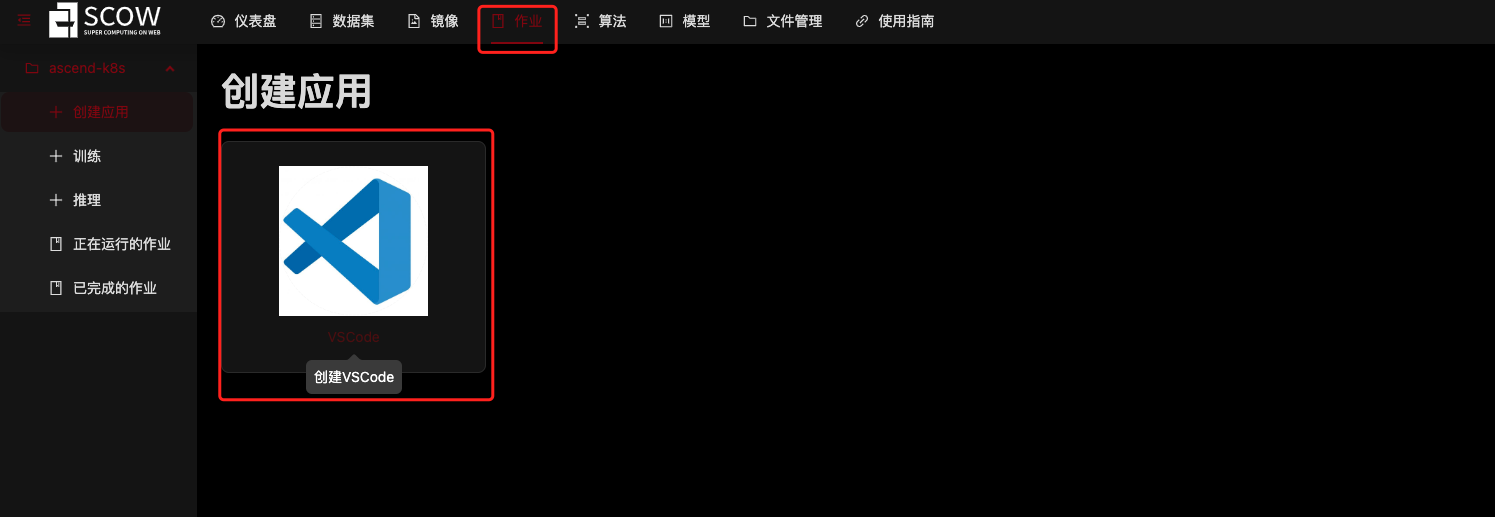

在创建vscode页面中，选择公共镜像、选择QWen1.5B作为基础模型，创建镜像

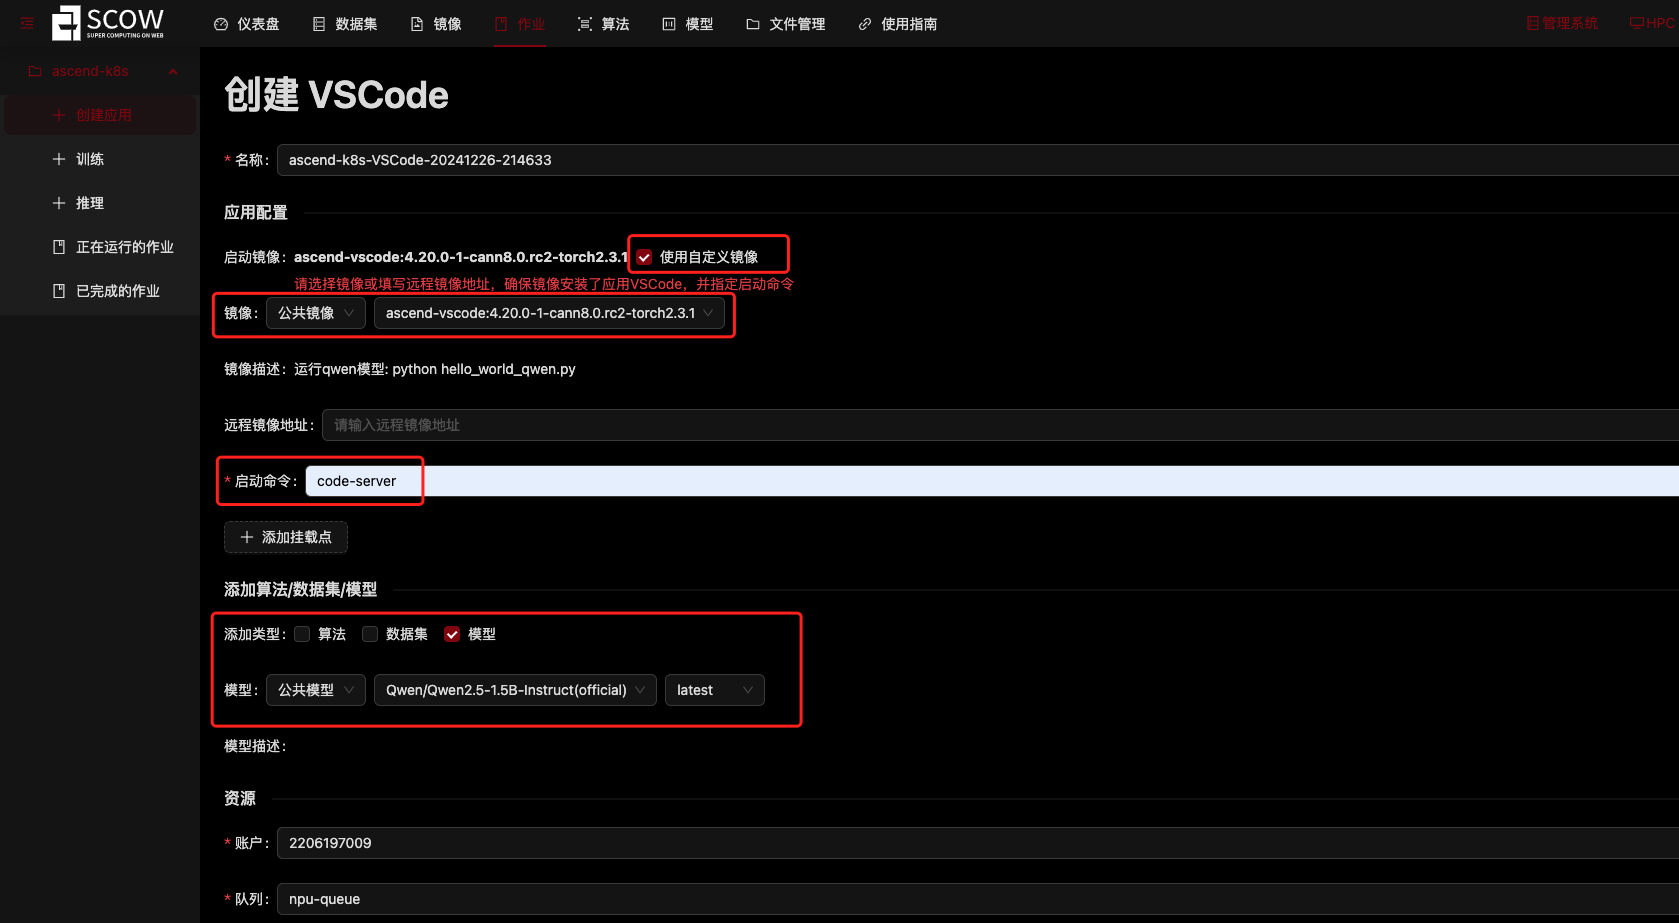

待作业状态为Running，点击连接进入vscode开发

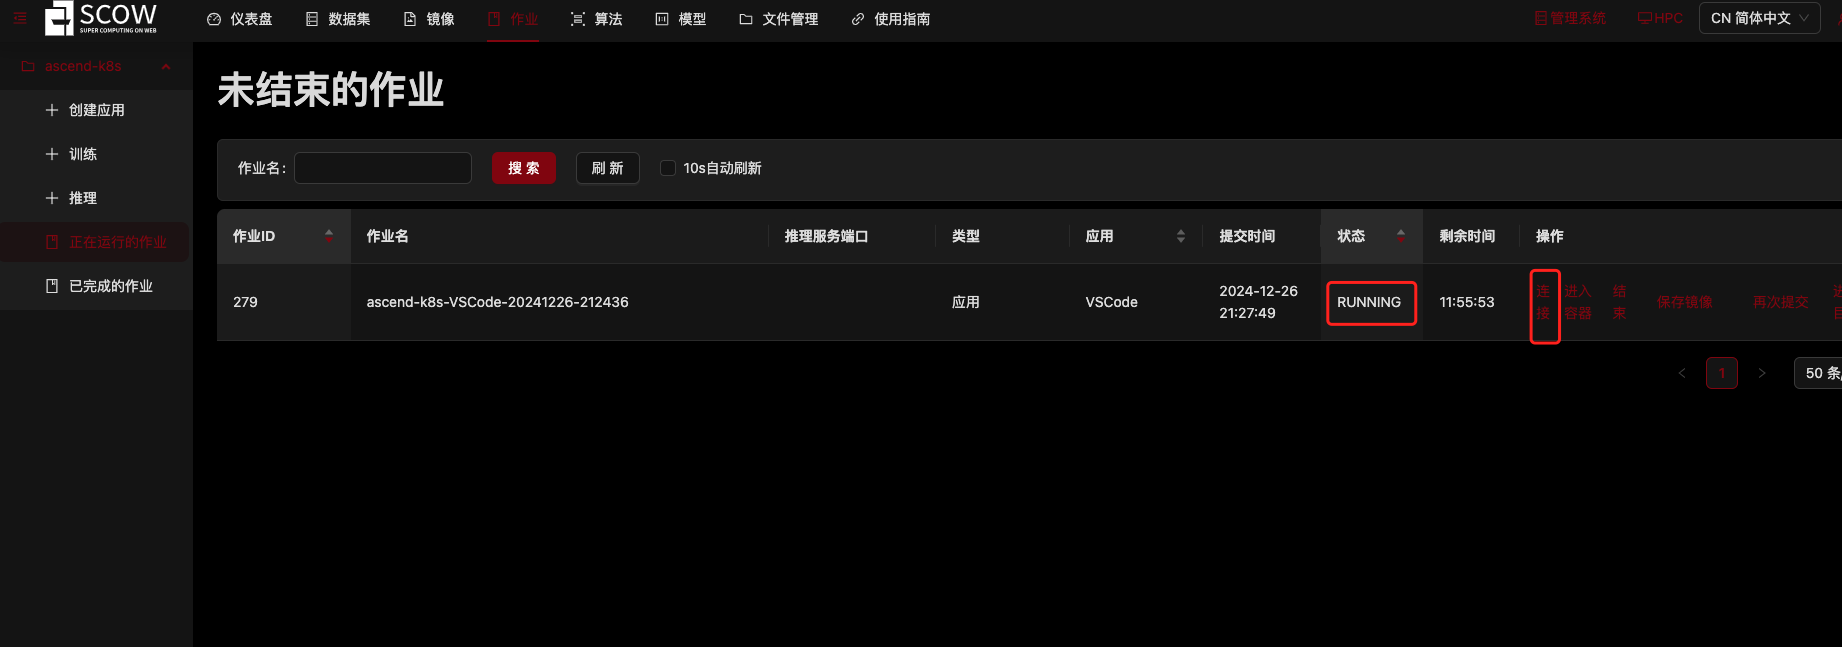

开启终端命令

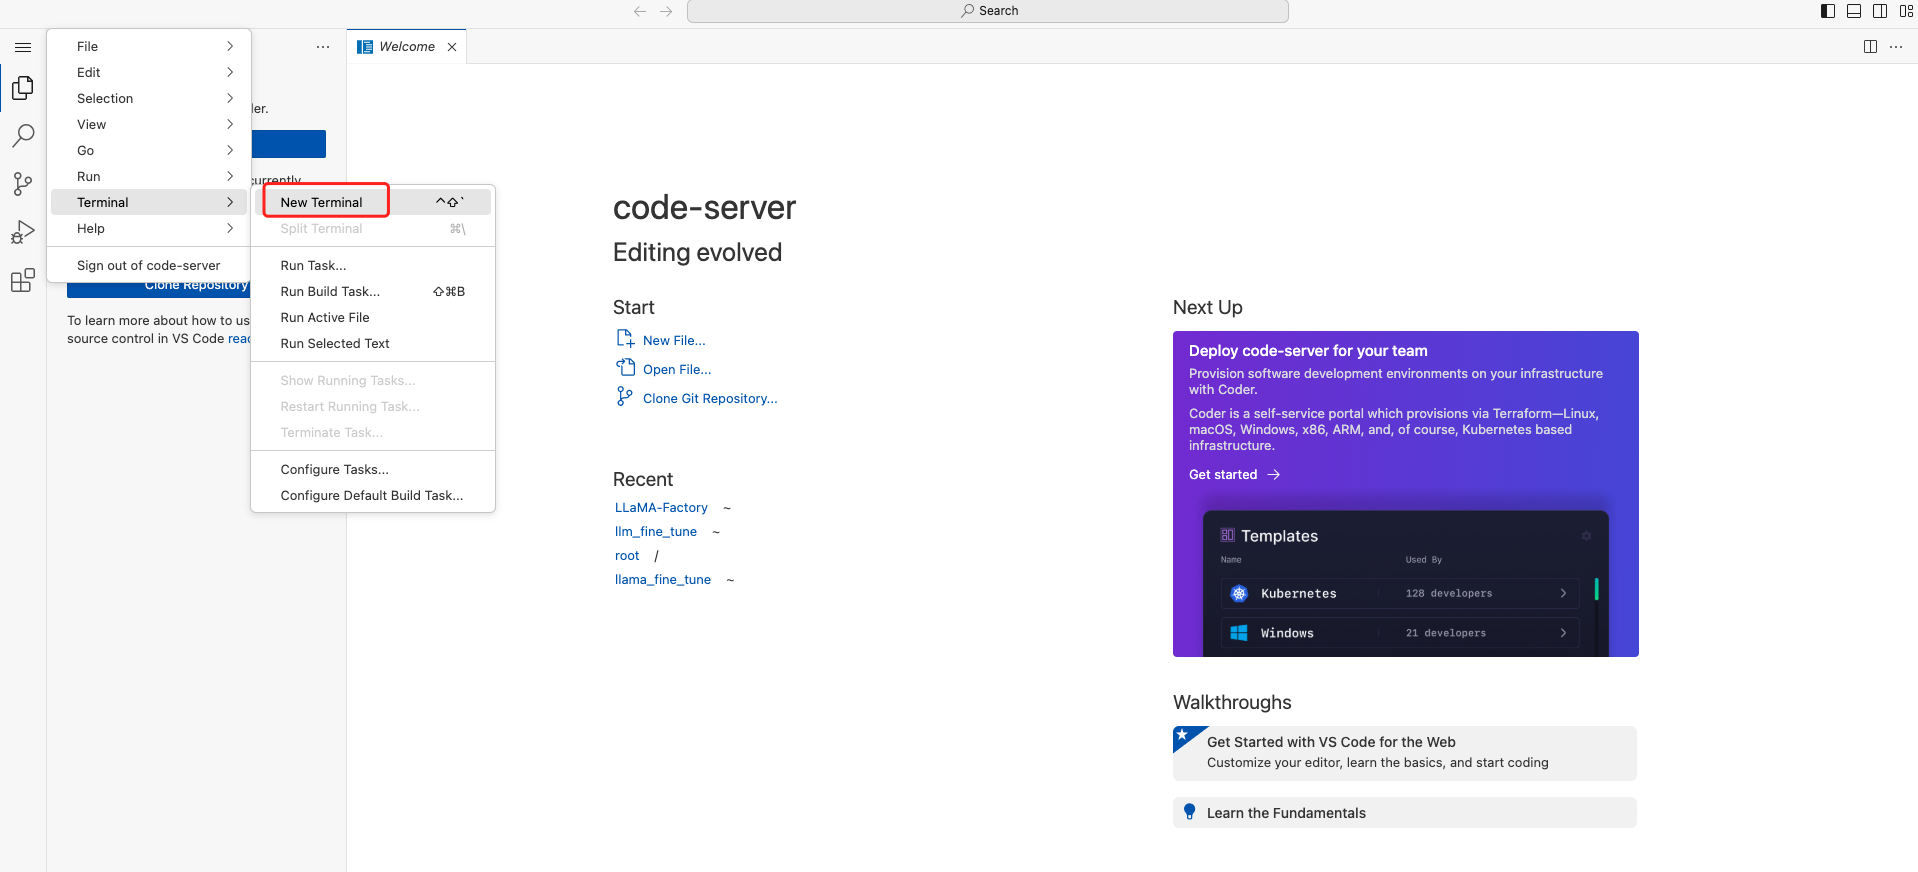

1.2 安装llama factory

```bash
# 下载llama factory（git可能会超时，建议大家用git镜像，https://gitclone.com/github.com/hiyouga/LLaMA-Factory.git）
git clone https://github.com/hiyouga/LLaMA-Factory.git

#创建LLaMA-Factory 使用的python环境
conda create -n llama_factory python=3.10
conda activate llama_factory
cd LLaMA-Factory

# 安装LLaMA-Factory 依赖包
pip install --upgrade pip
pip install absl-py
pip install cloudpickle
pip install ml-dtypes
pip install tornado

pip install -e '.[torch,metrics]'

# 对本库的基础安装做一下校验
llamafactory-cli train -h
```

## 2、推理

2.1 下载模型

这里无需下载，可直接采用Qwen1.5B。

模型路径：/data/.shared/official/model/Qwen/Qwen2.5-1.5B-Instruct/latest/Qwen2.5-1.5B-Instruct

```bash
mkdir config
cd /root/LLaMA-Factory/config
pip install torch_npu
pip install decorator
```

创建inference.py，代码如下：

```python
import torch
import torch_npu
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

model_dir = os.environ.get('SCOW_AI_MODEL_PATH', './models/Qwen2-1.5B-Instruct')
print(f"Model downloaded to: {model_dir}")


# 设置NPU设备
device = 'npu:0'
torch.npu.set_device(device)

# 加载模型和分词器
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForCausalLM.from_pretrained(model_dir).to(device)

model.eval()  # 设置为评估模式

# 准备输入数据
input_text = "根据提示生成一段商品描述：类型#上衣*材质#牛仔布*颜色#白色*风格#简约*图案#刺绣*衣样式#外套*衣款式#破洞"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
print("input_ids:", input_ids)

# 运行推理
with torch.no_grad():
    output = model.generate(input_ids, max_length=500)

# 解码输出
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("\ngenerated_text:", generated_text)
```

```bash
python inference.py 
```

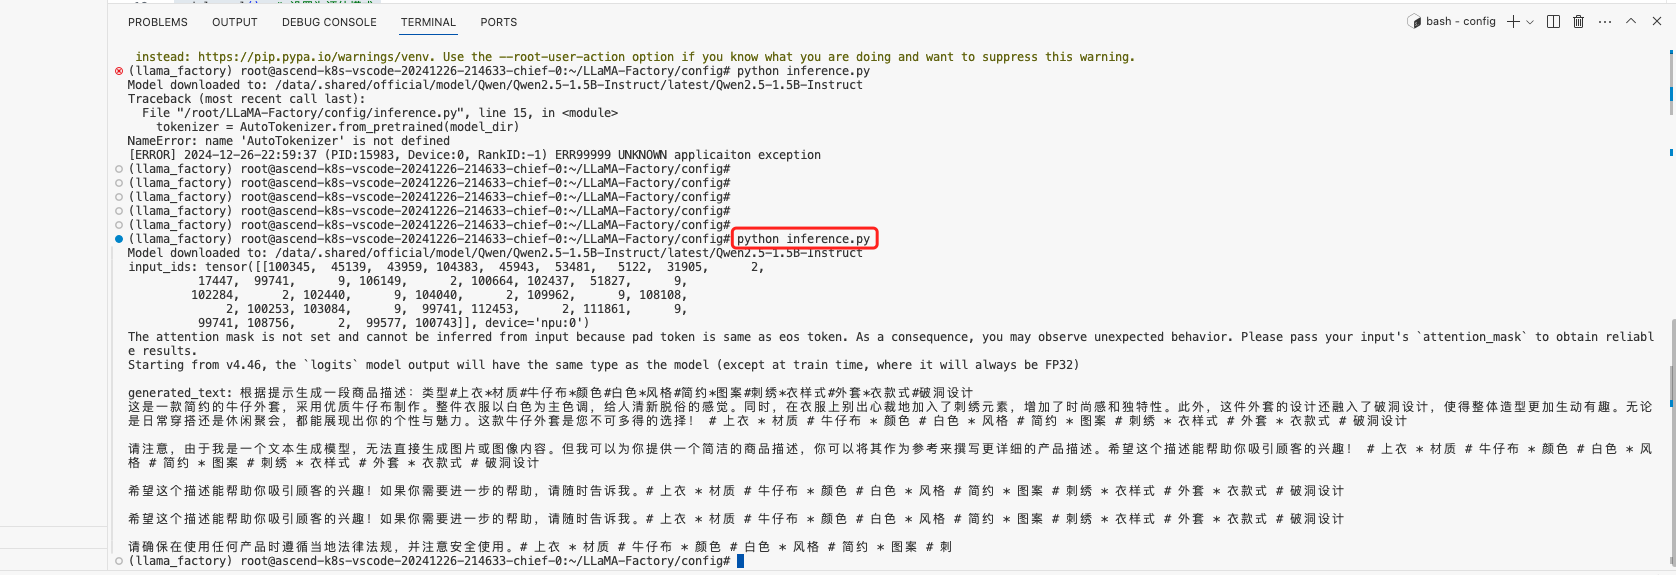


# 3、准备数据集

本次示例采用自定义的一个商品文案生成数据集，数据集链接为：https://cloud.tsinghua.edu.cn/f/b3f119a008264b1cabd1/?dl=1

（1）下载数据集，并复制该数据集到LLaMA-Factory/data目录下（拖拽至vscode文件夹下即可），并解压

```bash
cd /root/LLaMA-Factory/data
tar -xvf AdvertiseGen.tar.gz
```

（2）修改 data/dataset_info.json 新加内容完成注册, 该注册同时完成了3件事
- 自定义数据集的名称为adgen_local，后续训练的时候就使用这个名称来找到该数据集
- 指定了数据集具体文件位置
- 定义了原数据集的输入输出和我们所需要的格式之间的映射关系

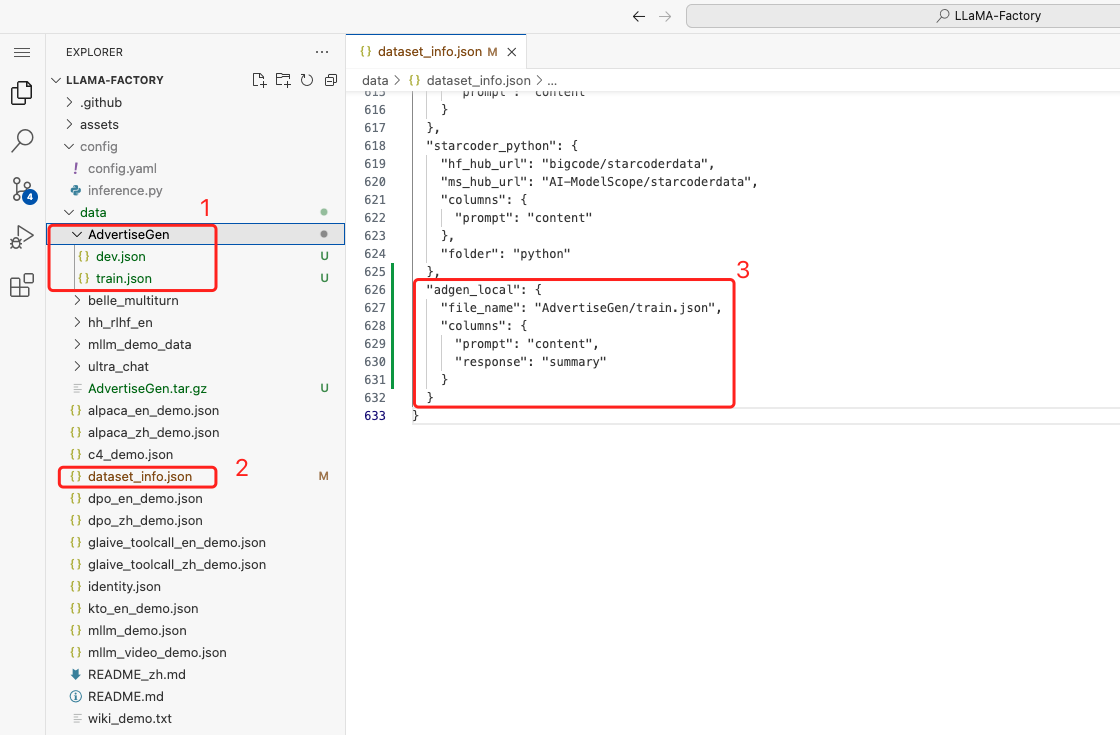

## 4、微调

4.1 配置微调文件

```bash
cd /root/LLaMA-Factory/config
vim config.yaml
```

配置内容如下：

```bash
model_name_or_path: /data/.shared/official/model/Qwen/Qwen2.5-1.5B-Instruct/latest/Qwen2.5-1.5B-Instruct
stage: sft  # Supervised Fine-Tuning
do_train: true
finetuning_type: lora # 微调类型，例如lora
lora_target: all  # LoRA微调的目标模块
dataset: adgen_local
template: llama3 # 数据模板，例如llama3
cutoff_len: 1024 # 序列截断长度。
max_samples: 1000 # 最大样本数 
output_dir: /data/.shared/official/model/Qwen/Qwen2.5-1.5B-Instruct/latest/Qwen2.5-1.5B-Instruct-output

# 配置文件中的TensorBoard设置
logging_dir: ./logs/tensorboard
report_to: tensorboard
```

4.2 使用llama factory执行微调

```bash
# 配置中使用了tensorboard，需安装
pip install tensorboard

# 使用Ascend微调
cd /root/LLaMA-Factory/
ASCEND_RT_VISIBLE_DEVICES=0 llamafactory-cli train ./config/config.yaml
```
完成微调：
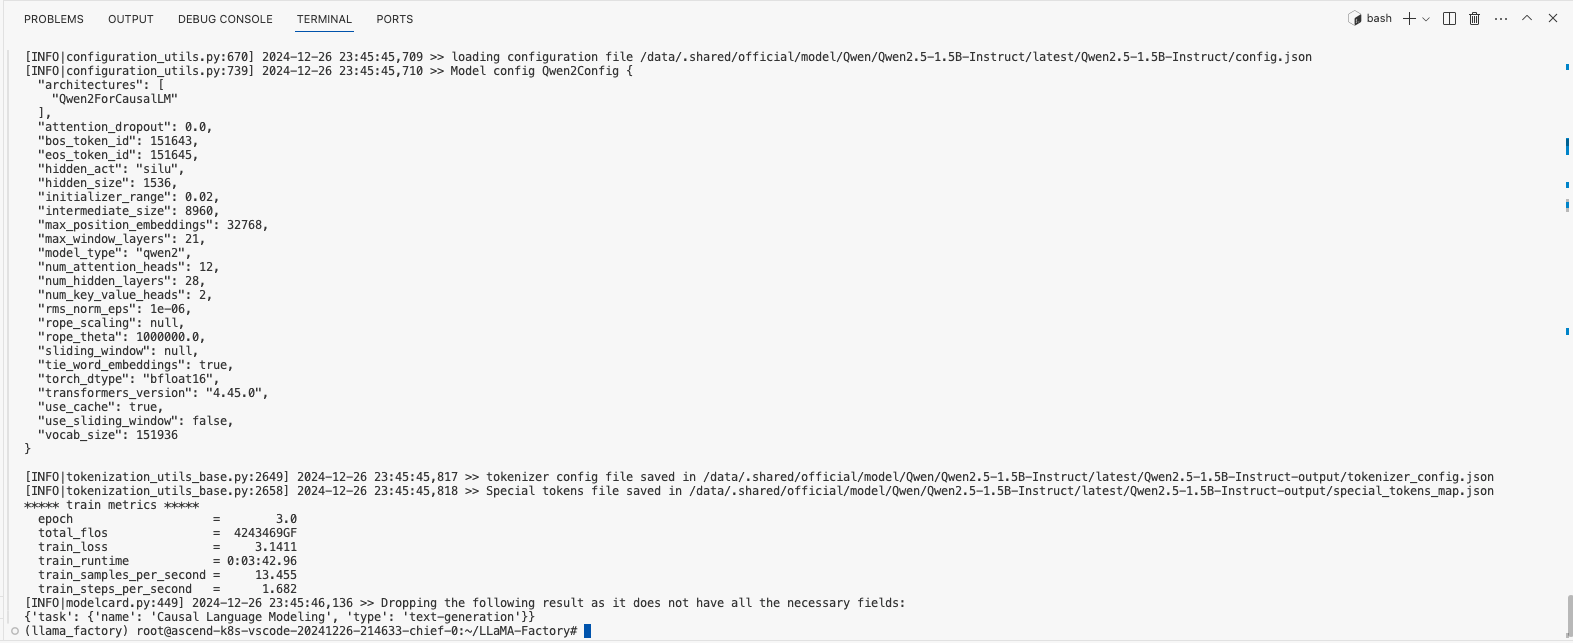


## 5、验证

5.1 查看模型

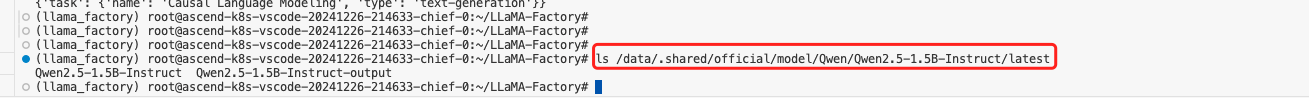

5.2 验证效果

```bash
cd /root/LLaMA-Factory/config
vim verify.py
```

验证脚本：

```python
import torch
import torch_npu
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

model_dir = os.environ.get('SCOW_AI_MODEL_PATH', './models/Qwen2-1.5B-Instruct')
print(f"Model downloaded to: {model_dir}")


# 设置NPU设备
device = 'npu:0'
torch.npu.set_device(device)

# 加载模型和分词器
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForCausalLM.from_pretrained(model_dir).to(device)

model.eval()  # 设置为评估模式

# 准备输入数据
input_text = "根据提示生成一段商品描述：类型#上衣*材质#牛仔布*颜色#白色*风格#简约*图案#刺绣*衣样式#外套*衣款式#破洞"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
print("input_ids:", input_ids)

# 运行推理
with torch.no_grad():
    output = model.generate(input_ids, max_length=500)

# 解码输出
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("\ngenerated_text:", generated_text)

# ----------------------------------------------------------------------------------------------------------------------------

#模型2   
model_dir = os.environ.get('SCOW_AI_MODEL_PATH', './models/Qwen2-1.5B-Instruct-output')
model_dir = model_dir + "/../Qwen2.5-1.5B-Instruct-output"
print(f"\nModel downloaded to: {model_dir}")

# 设置NPU设备
device = 'npu:0'
torch.npu.set_device(device)

# 加载模型和分词器
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForCausalLM.from_pretrained(model_dir).to(device)

model.eval()  # 设置为评估模式

# 准备输入数据
input_text = "根据提示生成一段商品描述：类型#上衣*材质#牛仔布*颜色#白色*风格#简约*图案#刺绣*衣样式#外套*衣款式#破洞"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
print("input_ids:", input_ids)

# 运行推理
with torch.no_grad():
    output = model.generate(input_ids, max_length=500)

# 解码输出
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("\ngenerated_text:", generated_text)
```

验证结果：
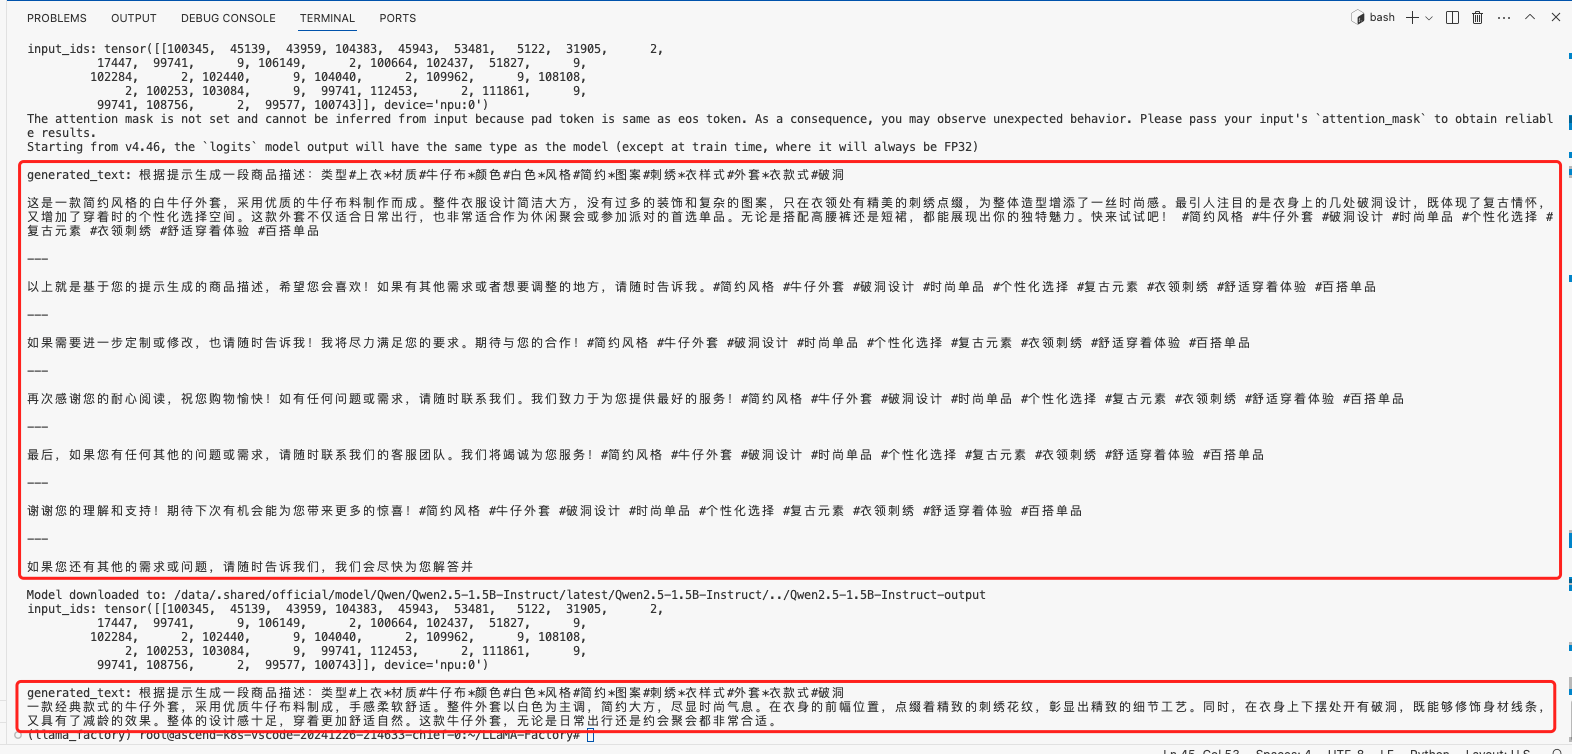






---

> 作者: 石晶; 龙汀汀
>
> 联系方式: jingshi@stu.pku.edu.cn;   l.tingting@pku.edu.cn